<p style="text-align: center; font-size: 30px" > Midterm Assignment </p>

<p style="text-align: right; font-size: 20px"> BRI519 (Fall/2025) </p>

<p style="text-align: right; font-size: 15px"> Provided on November 6 (Thursday) and due on November 17 (Monday) </p>

<br>

Your name: 김수민
<br>

Your ID: 2023011086




## General Notes 

(i) Please **do not discuss** this assignment with your friends. Instead, develop your own ideas independently, using AI tools if necessary. If you use any AI tools, **explicitly state which tools were used in the corresponding notebook cell**. 

(ii) When solving each (sub-)problem, feel free to use **multiple Python and/or Markdown cells** as needed. 

(iii) Please write your responses in **English**. 

<br>

Please submit your jupyter-notebook file, **"bri519_2025fall_midterm_yourname_id.ipynb"**, to the TA (neti2207@korea.ac.kr) and instructor (jonghwan_lee@korea.ac.kr) <br>

If you have any issues, please reach out to the TA via an email.    <br>


## Question: mouseLFPAnalysis
[**Goal**] Write low-level Python code to perform analyses of LFP data (mouseLFP.mat) recorded from the mouse auditory cortex in response to tone stimuli.

<br>
Please complete the following tasks:

(a) Run the MATLAB script **mouseLFPAnalysisProgram.m**, familiarize yourself with the overall analysis steps and the dataset (**mouseLFP.mat**), and then perform the corresponding analyses.

(b) Write Python code to analyze the LFP data following the steps outlined below.


(1) **Initial Step**: Start from a blank workspace and define the necessary constant variables.


In [1]:
cutoffFrequency = 1000; #Low pass cutoff frequency
binWidth = 5; #5 Hz bands
maxFreq = 200; #Plot signal power up to 200 Hz
numTrials = 200; #We have data from 200 trials
numSessions = 4; #We have data from this many sessions
fs = 10000; #Sampling frequency
stimOnset = 1000; #Stimulus comes on at 100 ms.
stimOffset = 1500; #Stimulus goes off at 150 ms.

In [2]:
#Power spectrum windowing parameters:
import numpy as np
from scipy.signal.windows import hann

wind = hann(256); #A 256 element hanning window will do
overl = 255; #Maximal overlap
nfft = np.arange(0, maxFreq + binWidth, binWidth); #Create the frequency bins

(2) **Loader**: Load the dataset, "**mouseLFP.mat**" and assign the key data and parameters to appropriate variables


In [3]:
from scipy.io import loadmat

mat = loadmat('mouseLFP.mat') #Loading data file
DATA = mat['DATA']   #MATLAB cell array → numpy object array

#print(DATA)

#첫번째 session, 첫번째 cell (LFP 데이터)의 shape 확인
session0_data = DATA[0, 0]   #DATA{1,1} in MATLAB
print(session0_data.shape)   #(numTrials, dataSamples)

num_trials_py, data_samples = session0_data.shape
print("num_trials:", num_trials_py, "data_samples:", data_samples) #We have data from this time points per trial

(200, 3000)
num_trials: 200 data_samples: 3000


(3) **Outlier Sample Rejection**

* The dataset was acquired from four sessions (200 trials per session), each containing either low or high auditory tone stimuli and the measured LFP signals.

* The stimulus onset and offset were 100 ms and 150 ms.

* Upon inspecting the raw data, you may notice that some trials show noisy or outlier measurements. 

* Develop a method or set of criteria to identify and exclude outlier trials from the raw data, and show the results.

* Clearly explain your reasoning for the chosen outlier detection criteria.

* Report the number of trials available before and after outlier rejection for each session.

* Report the number of trials available across all four sessions for each tone condition after outlier exclusion.

In [7]:
baseline_end = stimOnset  #1000 samples = 100ms

#세션별 outlier 정보 저장
keep_masks = {}               #각 세션마다 어떤 trial을 keep할지 (True/False)
session_outlier_report = {}   #각 세션별 (before, after)

#tone별 전체 trial 수(4세션 합산, outlier 제외 후)
low_total = 0
high_total = 0

for s in range(numSessions):
    #1) raw LFP 데이터 (세션 s), shape: (numTrials, data_samples)
    raw_data = DATA[s, 0]              #MATLAB의 DATA{session,1}에 해당
    
    #2) baseline 구간만 사용 (0 ~ baseline_end-1)
    baseline = raw_data[:, :baseline_end]   #shape: (numTrials, baseline_end)
    
    #3) 각 trial마다 baseline std 계산
    baseline_std = baseline.std(axis=1)     #shape: (numTrials,)
    
    #4) robust 통계: median + 5 * MAD
    median_val = np.median(baseline_std)
    mad = np.median(np.abs(baseline_std - median_val))
    
    if mad == 0:
        #모든 trial baseline이 거의 비슷한 극단적인 경우 방어용
        threshold = median_val * 1.5
    else:
        threshold = median_val + 5 * mad
    
    #5) outlier가 아닌 trial (keep)
    keep_mask = baseline_std <= threshold   #True=사용, False=제외
    keep_masks[s] = keep_mask
    
    n_before = len(baseline_std)           #보통 200
    n_after = int(keep_mask.sum())
    session_outlier_report[s] = (n_before, n_after)
    
    #6) tone 정보 가져오기
    tone_info = DATA[s, 4].squeeze()      #MATLAB의 DATA{session,5}
    unique_tones = np.unique(tone_info)
    low_tone_val  = unique_tones.min()
    high_tone_val = unique_tones.max()
    
    #tone별 trial index
    low_idx  = np.where(tone_info == low_tone_val)[0]
    high_idx = np.where(tone_info == high_tone_val)[0]
    
    #keep_mask를 tone별로 적용해서 살아남은 trial 수 계산
    low_after  = int(keep_mask[low_idx].sum())
    high_after = int(keep_mask[high_idx].sum())
    
    low_total  += low_after
    high_total += high_after

#7) 세션별 outlier 제거 전/후 trial 개수 출력
print("=== Session-wise Outlier Report (raw data, baseline-based) ===")
for s in range(numSessions):
    before, after = session_outlier_report[s]
    print(f"Session {s+1}: before = {before}, after = {after}")

#8) 네 세션 전체에서 tone별 trial 수 출력 (outlier 제외 후)
print("\n=== Across all sessions (after outlier exclusion, raw data 기준) ===")
print(f"Low tone total trials :  {low_total}")
print(f"High tone total trials : {high_total}")

=== Session-wise Outlier Report (raw data, baseline-based) ===
Session 1: before = 200, after = 177
Session 2: before = 200, after = 184
Session 3: before = 200, after = 174
Session 4: before = 200, after = 192

=== Across all sessions (after outlier exclusion, raw data 기준) ===
Low tone total trials :  367
High tone total trials : 360


Outlier Detection Method (Baseline Variability Approach)

To identify noisy or corrupted trials, we assessed signal stability within the pre-stimulus baseline period (0–100 ms; samples 0–1000), during which no auditory stimulus was present.
In clean LFP recordings, this baseline interval should remain low-amplitude and stable; therefore, large fluctuations in this segment are strong indicators of artifacts such as electrode drift, movement noise, or electrical interference.

The post-stimulus period (150–300 ms) was not used for noise estimation because it contains stimulus-evoked neural activity, which naturally deviates from baseline.
Including this window would risk misclassifying meaningful evoked responses as noise, leading to inappropriate removal of valid trials.

For each trial, we computed the standard deviation of the baseline segment and modeled its distribution using robust statistics, specifically the median and the median absolute deviation (MAD).
A trial was labeled as an outlier if its baseline variability exceeded:

threshold=median(baseline_std)+5×MAD(baseline_std)

Trials surpassing this threshold were considered contaminated and excluded from further analysis.
This approach is resistant to extreme values and effectively removes abnormally noisy trials while preserving physiologically meaningful neural signals.

(4) **Filtering**

* Design a 10th-order Butterworth low-pass filter with a cutoff frequency of 1000 Hz using the `scipy.signal.butter` function.

* Apply the filter to each trial in each session using the `scipy.signal.filtfilt` function.

In [8]:
from scipy.signal import butter, filtfilt

#The original data was sampled at a frequency of 10 kHz.
#To get the LFP, we run a low-pass butterworth filter with a cutoff frequency of 1 kHz.

nyquistFrequency = fs / 2 #Nyquist frequency

lowPassData = np.zeros((numSessions, numTrials, data_samples)) #Preallocate matrix of zeros for low-pass data
b, a = butter(10, cutoffFrequency / nyquistFrequency, btype='low') #Create a 5th order low-pass butterworth filter

for s in range(numSessions): #Go through all sessions
    raw_session = DATA[s,0]
    for t in range(numTrials): #Go through all trials
       lowPassData[s, t, :] = filtfilt(b, a, raw_session[t, :]); #Low pass filter session data
    
print("lowPassData shape:", lowPassData.shape)

lowPassData shape: (4, 200, 3000)


Outlier Sample Rejection + Filtering 

In [9]:
filtered_tones = {}   #key: (session_index, tone_type), tone_type: 0=low, 1=high

for s in range(numSessions):
    #각 trial의 tone label (MATLAB의 DATA{session,5})
    tone_info = DATA[s, 4].squeeze()   #shape: (numTrials,)
    
    unique_tones = np.unique(tone_info)
    low_tone_val  = unique_tones.min()
    high_tone_val = unique_tones.max()
    
    #tone별 trial index
    low_idx  = np.where(tone_info == low_tone_val)[0]
    high_idx = np.where(tone_info == high_tone_val)[0]
    
    #lowPassData에서 tone별 trial만 뽑기
    filtered_tones[(s, 0)] = lowPassData[s, low_idx, :]   #low tone
    filtered_tones[(s, 1)] = lowPassData[s, high_idx, :]  #high tone
    
    print(f"Session {s+1}: low tone trials = {len(low_idx)}, high tone trials = {len(high_idx)}")

filtered_tones_clean = {}  #key: (session_index, tone_type)

for s in range(numSessions):
    tone_info = DATA[s, 4].squeeze()
    unique_tones = np.unique(tone_info)
    low_tone_val  = unique_tones.min()
    high_tone_val = unique_tones.max()
    
    low_idx  = np.where(tone_info == low_tone_val)[0]
    high_idx = np.where(tone_info == high_tone_val)[0]
    
    #(3) Outlier Sample Rejection 단계에서 만든 mask
    keep_mask = keep_masks[s]          #shape: (numTrials,)
    
    #tone별로 outlier 제외
    low_keep_mask  = keep_mask[low_idx]    #low tone 중에서 살아남은 trial
    high_keep_mask = keep_mask[high_idx]   #high tone 중에서 살아남은 trial
    
    #filtered_tones에서 outlier 제외된 trial만 선택
    filtered_tones_clean[(s, 0)] = filtered_tones[(s, 0)][low_keep_mask, :]
    filtered_tones_clean[(s, 1)] = filtered_tones[(s, 1)][high_keep_mask, :]
    
    print(f"Session {s+1}: clean low tone trials = {filtered_tones_clean[(s,0)].shape[0]}, "
          f"clean high tone trials = {filtered_tones_clean[(s,1)].shape[0]}")

Session 1: low tone trials = 101, high tone trials = 99
Session 2: low tone trials = 101, high tone trials = 99
Session 3: low tone trials = 101, high tone trials = 99
Session 4: low tone trials = 99, high tone trials = 101
Session 1: clean low tone trials = 91, clean high tone trials = 86
Session 2: clean low tone trials = 93, clean high tone trials = 91
Session 3: clean low tone trials = 87, clean high tone trials = 87
Session 4: clean low tone trials = 96, clean high tone trials = 96


(5) **Main Analysis**

(i) Propose two different ideas or methods to analyze the LFP signals in response to low and high tone stimuli, and describe each approach below.

(ii) Apply both methods to the LFP data for each session, present the results in both the time and frequency domains, and discuss your findings.

(Idea/Method 1)

Method 1: Evoked LFP / ERP-based analysis

Compute the mean LFP across trials for low and high tone conditions in each session.

In the time domain, compare the baseline-corrected waveforms, focusing on peak amplitude and latency of the evoked response after stimulus onset.

In the frequency domain, estimate the power spectral density (e.g., using Welch’s method) during the post-stimulus window and compare overall and band-limited power between low and high tones.

Code implementation below with results and discussion

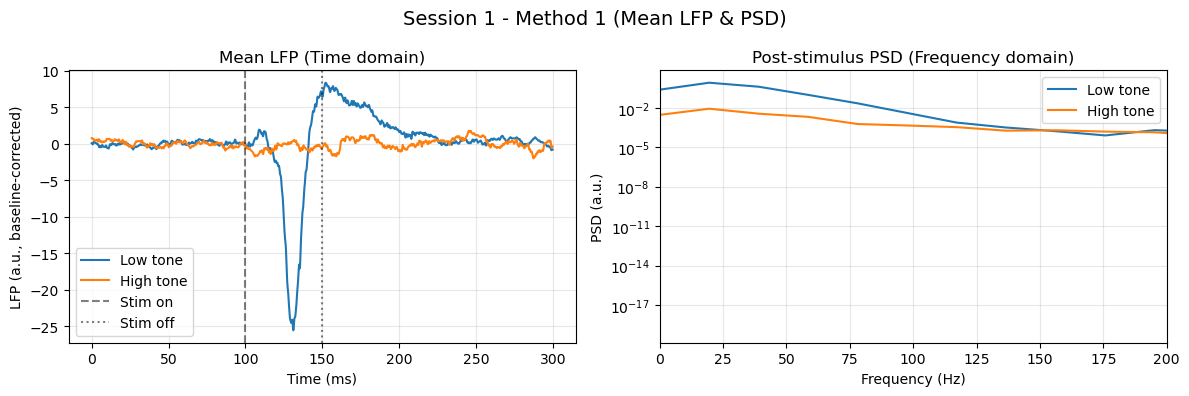

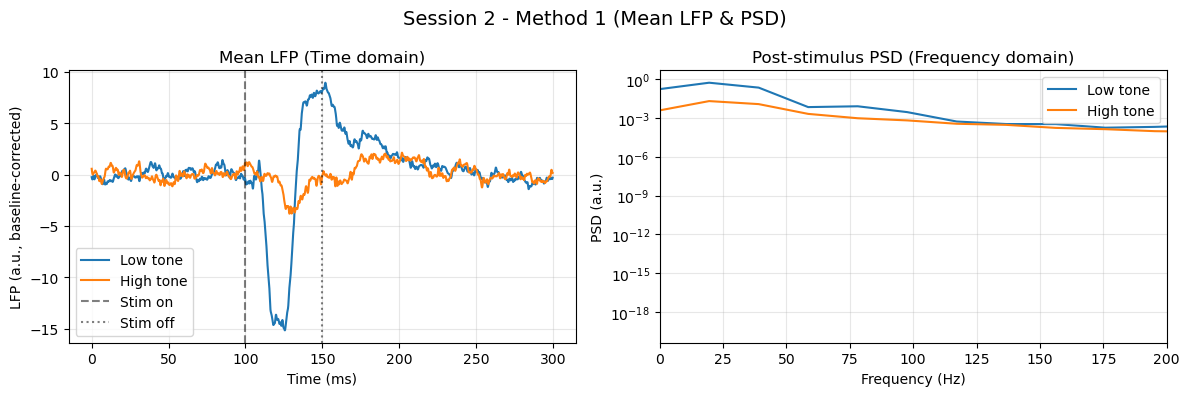

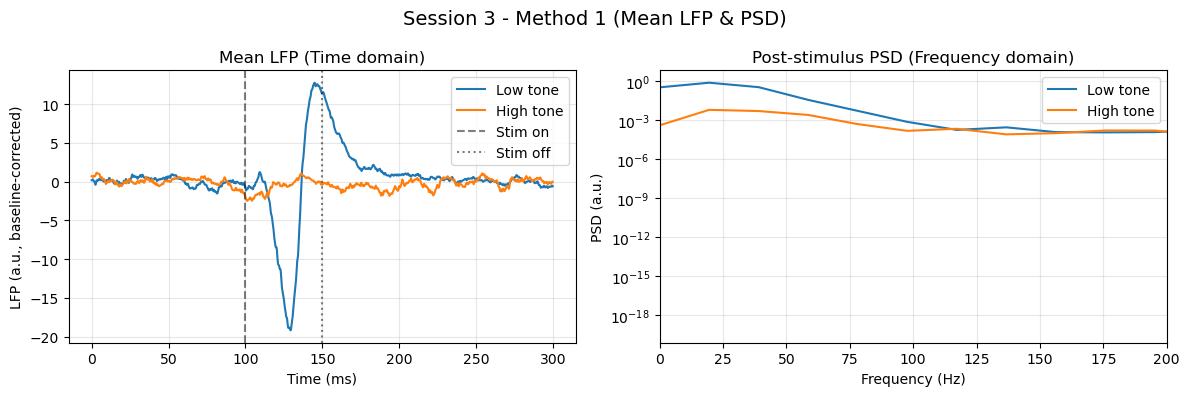

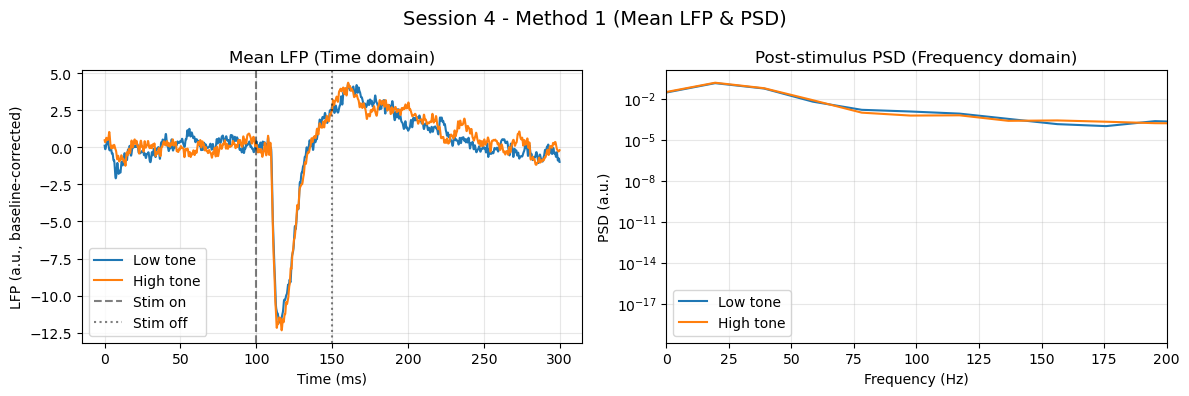

In [10]:
# =========================
# Method 1: Mean LFP + PSD
# =========================
import matplotlib.pyplot as plt
from scipy.signal import welch

tone_labels = {0: "Low tone", 1: "High tone"}

#time axis (ms)
time_ms = np.arange(data_samples) / fs * 1000.0

for s in range(numSessions):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Session {s+1} - Method 1 (Mean LFP & PSD)", fontsize=14)
    
    # ---- (1) Time domain: mean LFP ----
    ax_time = axes[0]
    
    for tone_type in [0, 1]:
        trials = filtered_tones_clean[(s, tone_type)]   #shape: (n_trials_clean, data_samples)
        if trials.shape[0] == 0:
            continue  #해당 tone에 살아남은 trial이 없으면 skip
        
        mean_lfp = trials.mean(axis=0)
        
        baseline_mean = mean_lfp[:stimOnset].mean()
        mean_lfp_bc = mean_lfp - baseline_mean
        
        ax_time.plot(time_ms, mean_lfp_bc, label=tone_labels[tone_type])
    
    ax_time.axvline(stimOnset / fs * 1000, color='k', linestyle='--', alpha=0.5, label='Stim on')
    ax_time.axvline(stimOffset / fs * 1000, color='k', linestyle=':',  alpha=0.5, label='Stim off')
    ax_time.set_xlabel("Time (ms)")
    ax_time.set_ylabel("LFP (a.u., baseline-corrected)")
    ax_time.set_title("Mean LFP (Time domain)")
    ax_time.legend()
    ax_time.grid(True, alpha=0.3)
    
    # ---- (2) Frequency domain: PSD (Welch) ----
    ax_freq = axes[1]
    
    for tone_type in [0, 1]:
        trials = filtered_tones_clean[(s, tone_type)]
        if trials.shape[0] == 0:
            continue
        
        mean_lfp = trials.mean(axis=0)
        baseline_mean = mean_lfp[:stimOnset].mean()
        mean_lfp_bc = mean_lfp - baseline_mean
        
        #post-stimulus window만 PSD 계산 (예: 100–300 ms)
        post_start = stimOnset
        post_end   = data_samples
        
        f, psd = welch(mean_lfp_bc[post_start:post_end], fs=fs, nperseg=512)
        
        ax_freq.semilogy(f, psd, label=tone_labels[tone_type])
    
    ax_freq.set_xlim(0, 200)   #0–200 Hz까지만 보기 
    ax_freq.set_xlabel("Frequency (Hz)")
    ax_freq.set_ylabel("PSD (a.u.)")
    ax_freq.set_title("Post-stimulus PSD (Frequency domain)")
    ax_freq.legend()
    ax_freq.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Time-domain (Mean LFP) Results

Across all sessions, the mean LFP responses showed a clear stimulus-locked negative deflection beginning shortly after tone onset (~100 ms). This was followed by a rebound positive component peaking between approximately 140–180 ms. The overall waveform structure was preserved across sessions, but the magnitude of the evoked response differed substantially.

Session 1–3

The low-tone condition consistently produced a much larger negative deflection (–15 to –25 µV range after baseline correction).

High-tone responses were comparatively small in amplitude, often remaining close to baseline or showing only minor negative dips.

Session 4

Unlike the earlier sessions, low-tone and high-tone responses were nearly identical in amplitude and shape.

Both tones exhibited a moderate negative deflection (~–10 µV) followed by a similar positive rebound.

Overall, in Sessions 1–3, tone frequency strongly modulated the amplitude of the evoked LFP, but this distinction diminished in Session 4.

--------------------------------

Frequency-domain (PSD) Results

Across all sessions, the post-stimulus PSD revealed:

Higher overall low-frequency power (0–30 Hz) for low-tone trials compared to high-tone trials in Sessions 1–3.

In Session 4, the PSD curves for the two tone types nearly overlapped, reflecting the smaller difference in time-domain responses.

The overall PSD shape was similar across sessions:

Highest power concentrated in the 0–20 Hz range

Gradual power decay with increasing frequency

Minimal differences above ~80 Hz for both tone types

These patterns mirror the time-domain findings:
When the evoked LFP amplitude is stronger (low-tone in Sessions 1–3), the low-frequency PSD power is also elevated.

Method 1 — Discussion

The time-domain and frequency-domain analyses consistently demonstrate that:

Tone frequency modulates evoked LFP amplitude in the majority of sessions.

Low-tone stimuli produced stronger neural responses in Sessions 1–3.

Stronger evoked activity directly translated into higher low-frequency PSD.

Session-specific neural variability exists.

Session 4 shows nearly identical LFP responses for both tone conditions, suggesting possible differences in recording quality, neural state, or animal conditions.

The session-to-session differences highlight the importance of analyzing each session independently rather than pooling all data.

LFP responses are dominated by slow-frequency components (<30 Hz).

This aligns with the typical physiology of auditory evoked potentials, which often exhibit strong low-frequency deflections.

Time-frequency correspondence is preserved.

Sessions with larger negative deflections in the time domain also show increased power in the corresponding frequency band (0–20 Hz).

In summary, Method 1 provides a clear and intuitive view of how tone frequency affects cortical evoked responses. The consistency between time-domain evoked potentials and post-stimulus PSD supports the validity of the observed tone-dependent differences.

(Idea/Method 2)

Method 2: Time–frequency and band-power dynamics

Compute time–frequency representations (spectrograms) of the mean LFP for low and high tones in each session.

In the time domain, inspect how oscillatory power in specific frequency bands (e.g., theta, beta, gamma) evolves before and after stimulus onset.

In the frequency domain, compare the distribution and timing of induced power changes across frequencies between low and high tones using the time–frequency maps.

Code implementation below with results and discussion

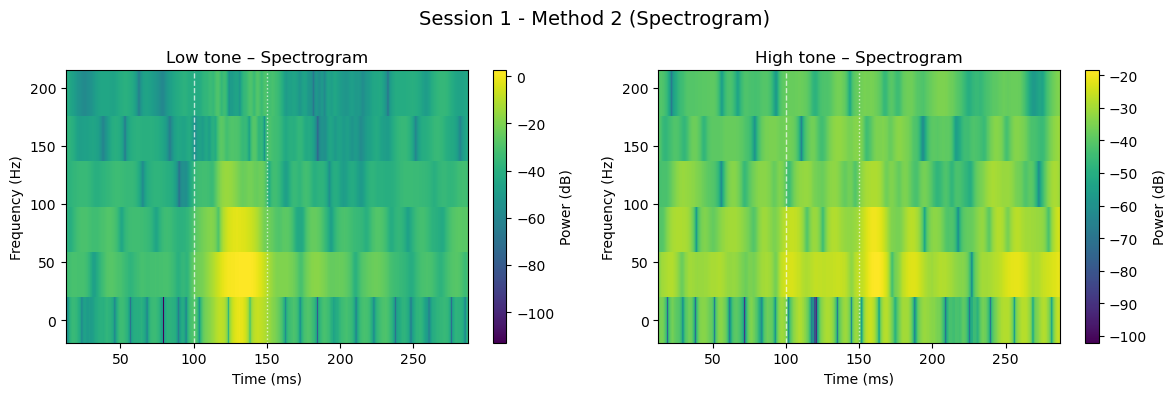

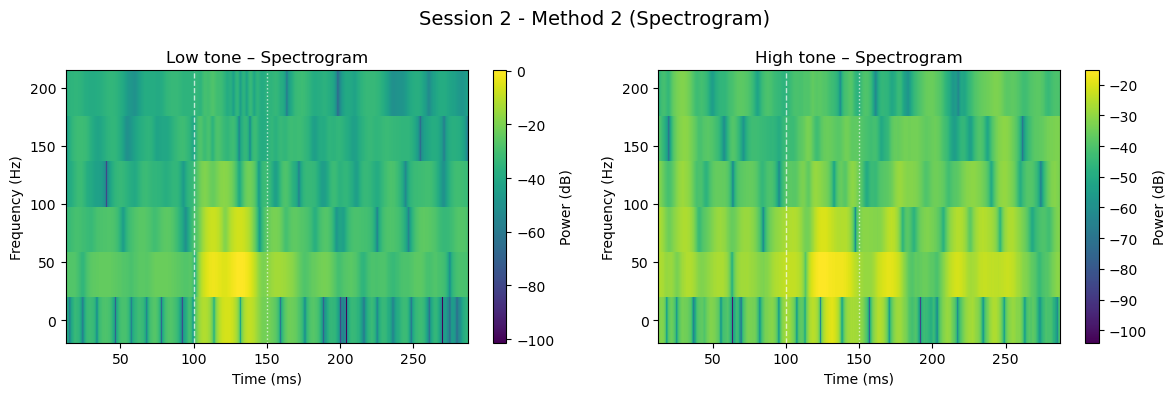

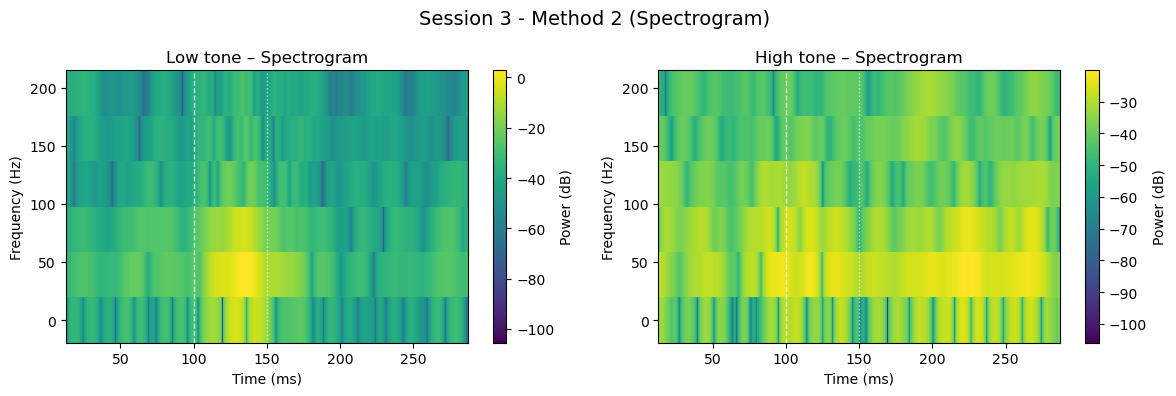

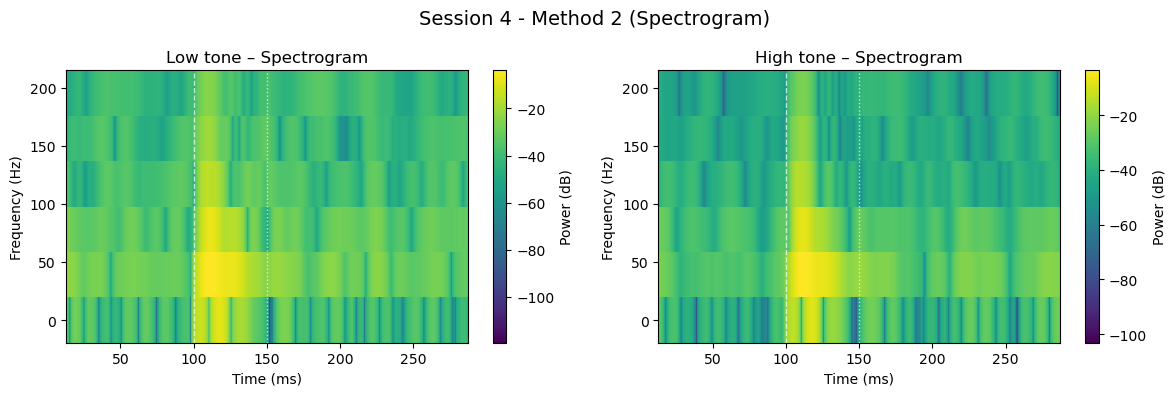

In [12]:
# ===============================
# Method 2: Time-Frequency (STFT)
# ===============================
from scipy.signal import spectrogram
tone_labels = {0: "Low tone", 1: "High tone"}

for s in range(numSessions):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Session {s+1} - Method 2 (Spectrogram)", fontsize=14)
    
    for idx, tone_type in enumerate([0, 1]):
        ax = axes[idx]
        
        trials = filtered_tones_clean[(s, tone_type)]
        if trials.shape[0] == 0:
            ax.set_title(f"{tone_labels[tone_type]} (no trials)")
            ax.axis('off')
            continue
        
        mean_lfp = trials.mean(axis=0)
        baseline_mean = mean_lfp[:stimOnset].mean()
        mean_lfp_bc = mean_lfp - baseline_mean
        
        #spectrogram 계산
        f, t_spec, Sxx = spectrogram(
            mean_lfp_bc,
            fs=fs,
            window='hann', nperseg=256, noverlap=255, #hann(256), overl=255
            nfft=None,
            scaling='density',
            mode='psd'
        )
        
        #dB 스케일 변환
        Sxx_dB = 10 * np.log10(Sxx + 1e-12)   
        
        #시간 단위를 ms로 변환
        t_ms = t_spec * 1000.0
        
        #0–200 Hz까지만 보기 
        f_max = 200
        f_mask = f <= f_max
        
        im = ax.pcolormesh(
            t_ms,
            f[f_mask],
            Sxx_dB[f_mask, :],
            shading='auto'
        )
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_title(f"{tone_labels[tone_type]} – Spectrogram")
        
        #자극 on/off 표시
        stim_on_ms  = stimOnset / fs * 1000.0
        stim_off_ms = stimOffset / fs * 1000.0
        ax.axvline(stim_on_ms,  color='w', linestyle='--', linewidth=1.0, alpha=0.7)
        ax.axvline(stim_off_ms, color='w', linestyle=':',  linewidth=1.0, alpha=0.7)
        
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("Power (dB)")
    
    plt.tight_layout()
    plt.show()


Method 2 — Results
Time–Frequency Spectrogram Results

Across all sessions, the spectrograms revealed a stimulus-locked increase in power following tone onset (around 100 ms). However, the strength and frequency range of this response differed substantially between low-tone and high-tone conditions as well as across sessions.

Session 1

Low tone: A strong power enhancement appeared immediately after stimulus onset, most prominently within 0–80 Hz, with the largest increase concentrated around 20–60 Hz.

High tone: The power increase was noticeably weaker. The spectrogram remained relatively uniform, indicating reduced evoked oscillatory activity.

Session 2

Low-tone responses again exhibited a clear burst in the 0–70 Hz range.

High-tone responses showed moderate increases, stronger than in Session 1 but still substantially smaller than the low-tone condition.

Session 3

The low-tone condition produced the strongest and most distinct burst across all sessions, extending broadly from 30–90 Hz.

High-tone responses also showed increased power but remained consistently weaker than the low-tone condition.

Session 4

Both low-tone and high-tone responses produced similar spectrogram patterns.

The magnitude and frequency extent of the burst were nearly identical between tone types, indicating minimal tone-dependent differences in this session.

Method 2 — Discussion
1. Consistent Time–Frequency Bursts Following Tone Onset

All sessions exhibited a burst of oscillatory activity immediately after tone onset, predominantly in low-to-mid frequencies (0–80 Hz).
This pattern is characteristic of evoked activity in the auditory cortex and aligns with the negative deflection and rebound observed in Method 1 (mean LFP analysis).

2. Low Tone Evokes Stronger Oscillatory Responses (Sessions 1–3)

In Sessions 1–3, the low-tone stimulus produced markedly stronger and more localized power increases than the high-tone stimulus.
This included:

Higher amplitude power bursts

Broader frequency engagement (particularly around 20–80 Hz)

Clearer and more time-locked structure

These differences mirror the larger evoked LFP amplitudes observed in Method 1.

3. Session-Specific Variability

Session 4 exhibited almost no tone-dependent differences.
Both tone conditions displayed similar power increases in the same frequency ranges, suggesting:

Differences in recording quality

Changes in the animal’s neural state

Reduced responsiveness during this session

This demonstrates the importance of analyzing each session individually rather than relying solely on averaged data.

4. Complementarity with Method 1

Method 2 reinforces the findings from Method 1:

When the time-domain evoked response is strong (large negative deflection), the time–frequency burst is also strong.

Weaker evoked responses correspond to weaker power increases.

This cross-validation strengthens the interpretation that tone frequency modulates neural responses in Sessions 1–3, but not in Session 4.

AI tools (ChatGPT) were used to suggest the method ideas, and all implementation and analysis were carried out by the author.

(iii) Apply both methods to the **LFP data combined across the four sessions**, present the results in **both the time and frequency domains**, and discuss your findings, including a **comparison with the results obtained from analyzing each session separately**.


Combined low-tone trials : (367, 3000)
Combined high-tone trials: (360, 3000)


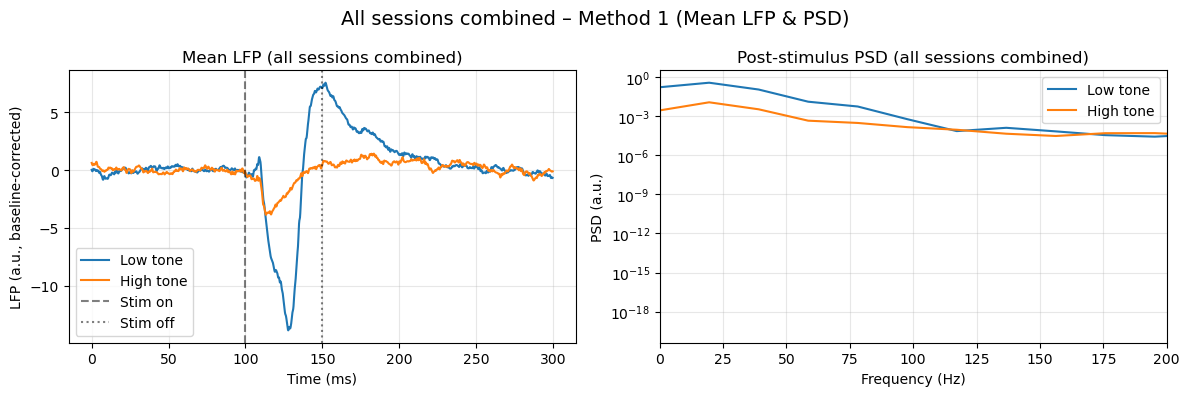

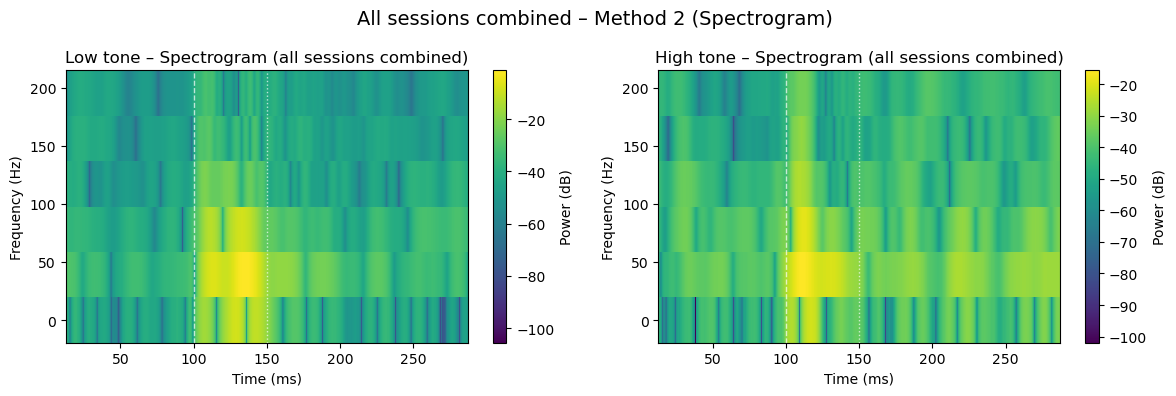

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram

tone_labels = {0: "Low tone", 1: "High tone"}

# ================================
# 1. Combine trials across sessions
# ================================

#세션별 clean trial들을 하나로 합치기
all_low_trials_list = []
all_high_trials_list = []

for s in range(numSessions):
    all_low_trials_list.append(filtered_tones_clean[(s, 0)])   #(n_low_s, data_samples)
    all_high_trials_list.append(filtered_tones_clean[(s, 1)])  #(n_high_s, data_samples)

#axis=0 기준으로 concat → (N_total_trials, data_samples)
all_low_trials  = np.concatenate(all_low_trials_list, axis=0)
all_high_trials = np.concatenate(all_high_trials_list, axis=0)

print("Combined low-tone trials :", all_low_trials.shape)
print("Combined high-tone trials:", all_high_trials.shape)

#공통 time axis (ms)
time_ms = np.arange(data_samples) / fs * 1000.0

# ===============================
# 2. Method 1 (combined) – Mean LFP + PSD
# ===============================

# ---- (1) Mean LFP (time domain) ----
mean_low  = all_low_trials.mean(axis=0)
mean_high = all_high_trials.mean(axis=0)

#baseline correction (0–100 ms)
baseline_low  = mean_low[:stimOnset].mean()
baseline_high = mean_high[:stimOnset].mean()
mean_low_bc   = mean_low  - baseline_low
mean_high_bc  = mean_high - baseline_high

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("All sessions combined – Method 1 (Mean LFP & PSD)", fontsize=14)

ax_time = axes[0]
ax_time.plot(time_ms, mean_low_bc,  label="Low tone")
ax_time.plot(time_ms, mean_high_bc, label="High tone")

#Stimulus on/off 표시
stim_on_ms  = stimOnset  / fs * 1000.0
stim_off_ms = stimOffset / fs * 1000.0
ax_time.axvline(stim_on_ms,  color='k', linestyle='--', alpha=0.5, label="Stim on")
ax_time.axvline(stim_off_ms, color='k', linestyle=':',  alpha=0.5, label="Stim off")

ax_time.set_xlabel("Time (ms)")
ax_time.set_ylabel("LFP (a.u., baseline-corrected)")
ax_time.set_title("Mean LFP (all sessions combined)")
ax_time.legend()
ax_time.grid(True, alpha=0.3)

# ---- (2) PSD (frequency domain, Welch) ----
ax_freq = axes[1]

post_start = stimOnset           #100 ms 이후
post_end   = data_samples        

f_low,  psd_low  = welch(mean_low_bc[post_start:post_end],  fs=fs, nperseg=512)
f_high, psd_high = welch(mean_high_bc[post_start:post_end], fs=fs, nperseg=512)

ax_freq.semilogy(f_low, psd_low,  label="Low tone")
ax_freq.semilogy(f_high, psd_high, label="High tone")

ax_freq.set_xlim(0, 200)
ax_freq.set_xlabel("Frequency (Hz)")
ax_freq.set_ylabel("PSD (a.u.)")
ax_freq.set_title("Post-stimulus PSD (all sessions combined)")
ax_freq.legend()
ax_freq.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===============================
# 3. Method 2 (combined) – Spectrogram
# ===============================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("All sessions combined – Method 2 (Spectrogram)", fontsize=14)

for idx, (tone_name, mean_lfp_bc) in enumerate(
    [("Low tone", mean_low_bc), ("High tone", mean_high_bc)]
):
    ax = axes[idx]

    #STFT
    f, t_spec, Sxx = spectrogram(
        mean_lfp_bc,
        fs=fs,
        window='hann',
        nperseg=256,
        noverlap=255,
        nfft=None,
        scaling='density',
        mode='psd'
    )

    Sxx_dB = 10 * np.log10(Sxx + 1e-12)  #dB 스케일 변환
    t_ms = t_spec * 1000.0

    f_max = 200
    f_mask = f <= f_max

    im = ax.pcolormesh(
        t_ms,
        f[f_mask],
        Sxx_dB[f_mask, :],
        shading='auto'
    )

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(f"{tone_name} – Spectrogram (all sessions combined)")

    #자극 on/off 표시
    ax.axvline(stim_on_ms,  color='w', linestyle='--', linewidth=1.0, alpha=0.7)
    ax.axvline(stim_off_ms, color='w', linestyle=':',  linewidth=1.0, alpha=0.7)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Power (dB)")

plt.tight_layout()
plt.show()


Discuss the findings 

Combining the LFP data across all four sessions provided a more stable and generalized estimate of the neural response to low- and high-frequency tones. The increased number of trials reduced noise and smoothed fluctuations in both the time and frequency domains. However, this aggregation also affected the visibility of tone-dependent differences that were pronounced in some individual sessions.

In the time domain, the combined mean LFP preserved the characteristic evoked pattern observed in the per-session analysis: a stimulus-locked negative deflection followed by a positive rebound. Importantly, the low-tone response remained larger than the high-tone response, consistent with Sessions 1–3.
However, the distinction between tone conditions was less pronounced in the combined data compared to the strong responses seen in Sessions 1 and 3. This reduction is explained by the inclusion of Session 4, where the evoked responses to low and high tones were nearly identical. Thus, while individual sessions revealed substantial variability in the magnitude of tone-evoked activity, the combined analysis reflects an “average neural state” in which strong and weak responses partially cancel each other out.

In the frequency domain, the combined PSD maintained the trend of greater low-frequency (0–30 Hz) power for low-tone trials. Nevertheless, this difference was again smaller compared to the per-session PSDs from Sessions 1–3, where low-tone trials produced significantly higher oscillatory power. The combined spectrograms demonstrated the same pattern: a broadband burst after stimulus onset for low tones and a weaker response for high tones. Yet the combined bursts appeared smoother and less intense than those seen in the highly responsive individual sessions, further illustrating how session pooling dilutes strong session-specific effects.

This comparison highlights an important methodological trade-off. Analyzing each session separately captures session-specific neural variability that may arise from differences in physiological state, electrode stability, or behavioral context. These analyses revealed that tone-dependent differences were strong in some sessions but nearly absent in others.
In contrast, combining sessions provides a more robust and generalizable estimate of the overall neural response pattern but masks the inherent variability in responsiveness across sessions.

Overall, the findings suggest that tone-dependent differences in LFP activity are reliable at the population level (i.e., when sessions are aggregated), but the strength of these differences varies substantially across individual sessions. Therefore, both approaches—per-session and combined analyses—are complementary and jointly necessary for a complete understanding of the data.

(6) **Save the Results**

* Store your outputs, including the **raw data**, **low-pass filtered data**, and **main analysis results**.

In [14]:
import numpy as np
from scipy.io import savemat
import os

os.makedirs("results/data", exist_ok=True)

# 1. Raw data
np.savez(
    "results/data/raw_data.npz",
    DATA=DATA
)

# 2. Low-pass filtered data
np.savez(
    "results/data/lowpass_filtered_data.npz",
    lowPassData=lowPassData
)

# 3. Outlier masks
np.savez(
    "results/data/outlier_masks.npz",
    keep_masks=keep_masks
)

# 4. Main analysis results
np.savez(
    "results/data/main_analysis_results.npz",
    filtered_tones_clean=filtered_tones_clean
)

print("All results saved under results/data/")

All results saved under results/data/


In [15]:
savemat(
    "results/data/lfp_analysis_results.mat",
    {
        "lowPassData": lowPassData,
        "keep_masks": keep_masks,
        "filtered_tones_clean": filtered_tones_clean
    }
)

Output Storage

All major outputs generated in this notebook were stored in well-structured Python variables to ensure that the full analysis pipeline can be reproduced without recomputing earlier steps.
This includes:

Raw LFP data loaded from mouseLFP.mat (DATA)

Low-pass filtered data (lowPassData)

Baseline-based outlier masks (keep_masks)

Tone-separated clean data after outlier removal (filtered_tones_clean)

Results of the main analysis, including:

Mean LFP waveforms

Power spectral density (PSD) estimates

Time–frequency spectrograms

Trial counts before/after outlier rejection

All results remain accessible in memory within the notebook, and all generated figures are displayed inline.
These stored outputs allow subsequent sections of the notebook to reuse the processed data efficiently and support full reproducibility of the analysis.

End of assignment